In [12]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:
# Analyze reliability, bandwidth, energy
data = []
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../**/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [255, 1, 2, 4, 8] + list(range(16, 256, 32)):
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          continue

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                for i in range(65535):
                    for j in range(48):
                        if j in [2, 7, 16, 19, 23, 24, 29, 33, 38, 39, 43]: #[16, 19,24,29,38,43]:
                            continue
                        confmat[refvec[i][j]][postread[i][j]] += 1
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        energy_tot = power_tot * dt2
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = energy_tot / confmat.sum() / bpc
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": alias, "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data).sort_values(["alias", "att"])
data

1bpc_test


,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_test,1,1,0.029232501983642578,0.028958,0.002571,3.070874e-11,3.667356e-19,8.373538e+07,0.000549,...,0.023438,65536,125152,321752,59604,65536,2895783,3636667,249763,1022302


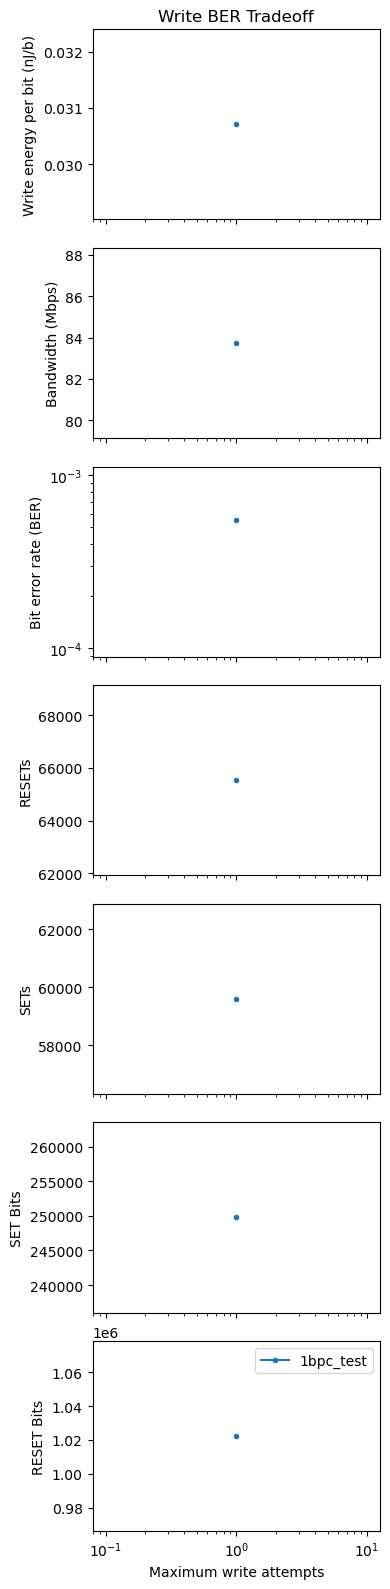

In [14]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  # axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  # axs[1].set_yscale("log")
  axs[1].set_ylabel("Bandwidth (Mbps)")
  # axs[2].plot(d["att"], d["edp"], ".-", label=alias)
  # axs[2].set_yscale("log")
  # axs[2].set_ylabel("EDP (J•s/b$^2$)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  # axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  # axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  # axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  # axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()